## <span style="color:#db7d60">Setup</span>

In [2]:
%load_ext autoreload
%autoreload 2

import json
import math
import pickle
import numpy as np
import pandas as pd
import textwrap
import sys
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# pUtil needs to be loaded from the root directory
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

from matplotlib.ticker import ScalarFormatter, FuncFormatter

import pUtil
from analysis_common import *
import data_manager
import analysis as anal

import vector
from particle import Particle
from particle import PDGID

plt.rcParams['figure.figsize'] = (21, 6)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

/global/homes/e/eshy/.local/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


## <span style="color:#db7d60">Analysis</span>

In [ ]:
anal.plotting.default_dpi = 100

# IMPORTANT: This function assumes ALL provided models are from the same dataset!!!!
@staticmethod
def compare_distributions_all(model_names, model_legend_title, column_name=None, normalized=False, use_log=False, out_file=None):
    unit = ''
    if column_name in ['e', 'pt', 'px', 'py', 'pz']:
        unit = '(MeV)'
    
    # Set up plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=False, sharey=True, dpi=anal.plotting.default_dpi)
    lab = column_name
    if column_name == 'eta':
        lab = 'η'
    elif column_name == 'theta':
        lab = 'θ'
    elif column_name == 'phi':
        lab = 'φ'
    fig.suptitle(f'{lab} Distribution for All Outgoing Particles {"(Normalized)" if normalized else ""}')
    
    fig.supxlabel(f'{lab} {unit}', fontsize=16)
    fig.supylabel('log(Frequency)' if use_log else 'Frequency', fontsize=16)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # This data will be grabbed from the first model to maintain consistency
    bin_settings = anal.plotting.get_common_data(model_names[0])
    range = (bin_settings[column_name]['min'], bin_settings[column_name]['max'])
    n_bins = bin_settings[column_name]['bins']
    
    relevant_column_pos = anal.plotting.verbose_columns.index(column_name)
    
    # The input data
    real_verbose_data = data_manager.load_verbose_dataset(pUtil.get_model_preparation_dir(model_names[0]) / 'real_verbose_test_particles.csv', pad_token = np.nan)
    all_instances_of_this_column_real = []
    for event in real_verbose_data:
        secondaries = event[1:]
        for particle in secondaries:
            if not np.isnan(particle[relevant_column_pos]):
                all_instances_of_this_column_real.append(particle[relevant_column_pos])
    
    # The sampled datas 
    sampled_columns_instances = {}
    for model_name in model_names:
        sampled_verbose_data = data_manager.load_verbose_dataset(pUtil.get_latest_sampling_dir(model_name) / 'untokenized_samples_verbose.csv', pad_token = np.nan)
        all_instances_of_this_column_sampled = []
        for event in sampled_verbose_data:
            secondaries = event[1:]
            for particle in secondaries:
                if not np.isnan(particle[relevant_column_pos]):
                    all_instances_of_this_column_sampled.append(particle[relevant_column_pos])
        sampled_columns_instances[model_name] = all_instances_of_this_column_sampled
    
    ax.set_yscale('log' if use_log else 'linear')
    ax.hist(all_instances_of_this_column_real, range=range, bins=n_bins, density=normalized, label=model_legend_title[0], color='black', histtype='step', linewidth=2)
    for idx, (model_name, sampled_column_instance) in enumerate(sampled_columns_instances.items()):
        ax.hist(sampled_column_instance, range=range, bins=n_bins, density=normalized, label=model_legend_title[idx + 1], color=anal.plotting.colors[idx], histtype='step', linewidth=2)
        
    # Finishing touches and show and/or save
    fig.legend(loc='upper left', bbox_to_anchor=(0.175, 0.9), fontsize=16)
    fig.tight_layout()
    if out_file != None:
        fig.savefig(out_file, bbox_inches='tight')
    fig.show()

# Custom formatter to force scientific notation for small numbers
def sci_notation(x, pos):
    return f'{x:.0e}'  # or '{:.1e}' for 1 decimal

@staticmethod
def plot_validation_run(model_names, model_legend_title, y_lim=None, x_lim=None, use_log=False, out_file=None, plot_lr_schedule=False):
    """
    Wrapper to plot a training run. Handles plotting lines and markers for training and validation loss.
    """
    
    if not isinstance(model_names, list):
        model_names = [model_names]
    
    # Set up plot
    fig, ax = plt.subplots(figsize=anal.plotting.default_figsize, dpi=anal.plotting.default_dpi)
    if len(model_names) < 3:
        fig.suptitle(f'Training Progress for {model_names}', fontsize=16)
    else:
        fig.suptitle(f'Training Progress for various models', fontsize=16)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax.set_xlabel("Iteration", fontsize=16)
    ax.set_ylabel("Val Loss", fontsize=16)
    if y_lim is not None:
        ax.set_ylim(y_lim)
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if use_log:
        ax.set_yscale('log')
        
    for idx, model_name in enumerate(model_names):
        # Parse model data
        model_data = anal.tables.get_all_data(model_name)
        min_val_row = model_data.checkpointed_df.loc[model_data.checkpointed_df['val_loss'].idxmin()]
        final_row = model_data.running_df.iloc[-1]
        
        if plot_lr_schedule:
            config_filepath = pUtil.get_model_config_filepath(model_name)
            with open(config_filepath, 'r') as f:
                model_config = json.load(f)
                training_conf = model_config.get('training_config', {})
                lr_scheduler = training_conf.get('lr_scheduler', 'cosine_annealing_with_warmup')
                warmup_iters = training_conf .get('warmup_iters', 0)
                lr_decay_iters = training_conf .get('lr_decay_iters', 0)
                learning_rate = training_conf .get('learning_rate', 0)
                min_lr = training_conf .get('min_lr', 0)
                base_lr_decay_mult = training_conf .get('base_lr_decay_mult', 1)
                cycle_steps_mult = training_conf .get('cycle_steps_mult', 1)
            iters = [i for i in range(model_data.running_df['iter'].max())]
            lrs = [anal.plotting._get_lr(it, lr_scheduler, warmup_iters, lr_decay_iters, min_lr, learning_rate, cycle_steps_mult, base_lr_decay_mult) for it in iters]
            
            # Another y-axis for lr as otherwise it would be too small to see 
            lrax = ax.twinx()
            lrax.plot(iters, lrs, label=f'Learning rate', color="magenta", linestyle='solid', linewidth=1)
            lrax.tick_params(axis='y', labelcolor="magenta")
            # Decimal can be confusing so we switch to scientific
            lrax.yaxis.set_major_formatter(FuncFormatter(sci_notation))
            
        # Do plot
        ax.plot(model_data.running_df['iter'], model_data.running_df['val_loss'], label=model_legend_title[idx], color=anal.plotting.colors[idx], linestyle='solid', linewidth=2)
        # ax.scatter(min_val_row['iter'], min_val_row['val_loss'], label=f'Min Saved Val Loss ({model_name}; {min_val_row["val_loss"]:.4f})', color=plotting.colors[idx], marker='o')
        ax.annotate(model_legend_title[idx], xy=(final_row['iter'], final_row['val_loss']), xytext=(final_row['iter'] * 1.005, final_row['val_loss'] - 0.02), fontsize=14, color=anal.plotting.colors[idx])
        
    # Final touches and show and/or save
    fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=16)
    fig.tight_layout()
    plt.grid()
    if out_file != None:
        fig.savefig(out_file, bbox_inches='tight')
    fig.show()
    
    return fig, ax

(<Figure size 2100x600 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Val Loss'>)

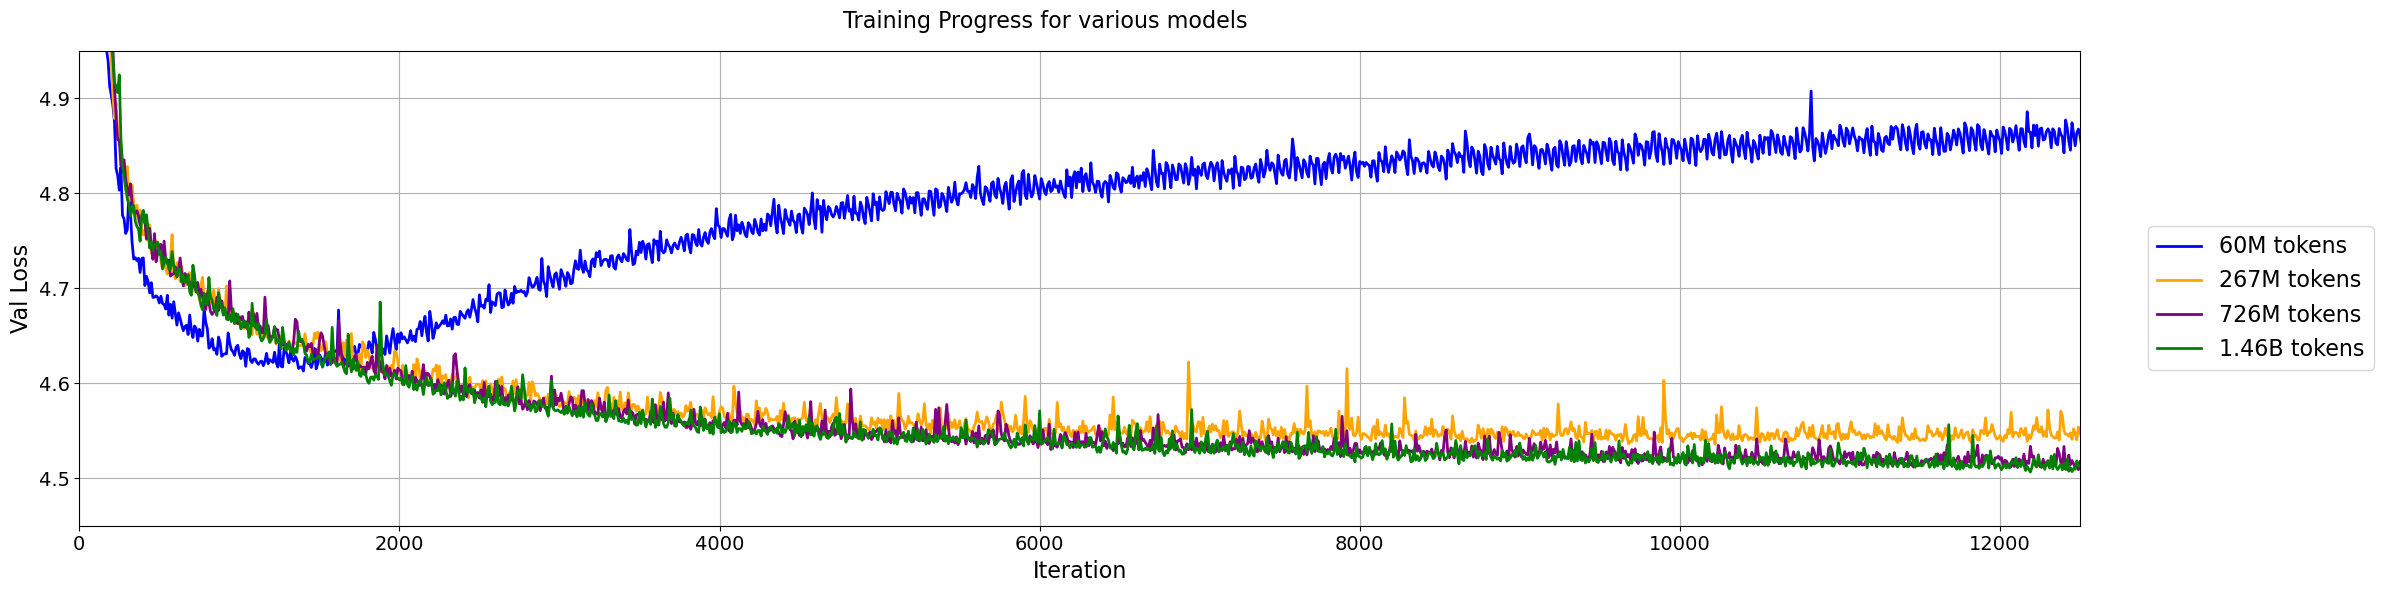

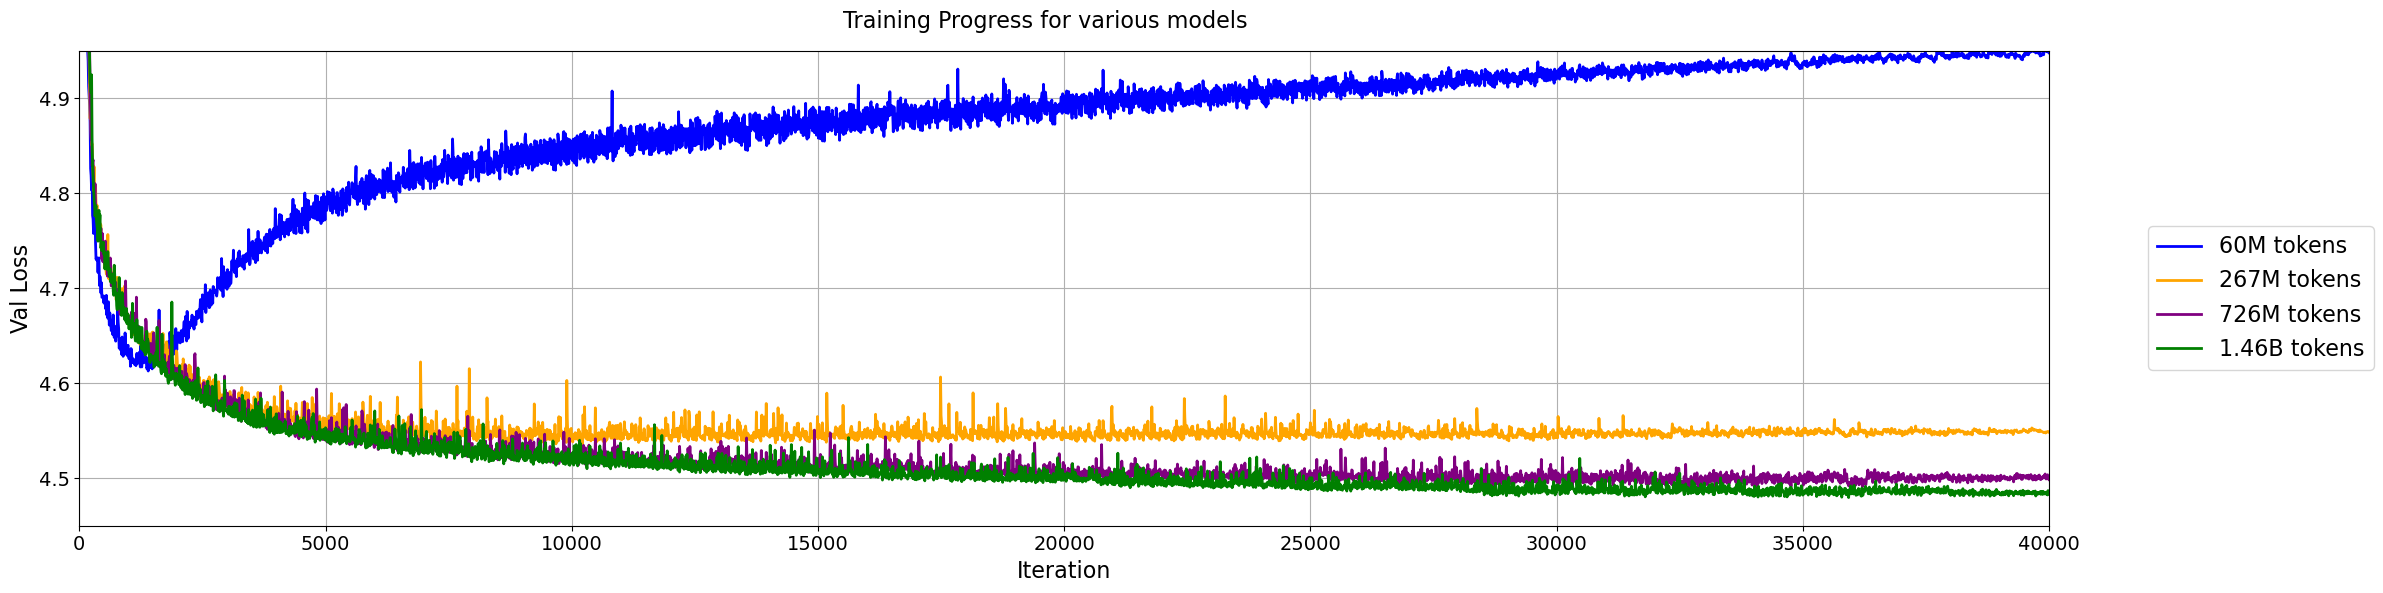

In [6]:
titles = ['60M tokens', '267M tokens', '726M tokens', '1.46B tokens']
models = ['model_exp10_500k_lr1', 'model_exp10_2M_lr1', 'model_exp10_5M_lr1', 'model_10M_9_exp9_vdi_2']

plot_validation_run(models, model_legend_title=titles, use_log=False, y_lim=(4.45, 4.95), x_lim=(0, 12500))
plot_validation_run(models, model_legend_title=titles, use_log=False, y_lim=(4.45, 4.95), x_lim=(0, 40000))

pt
eta
phi


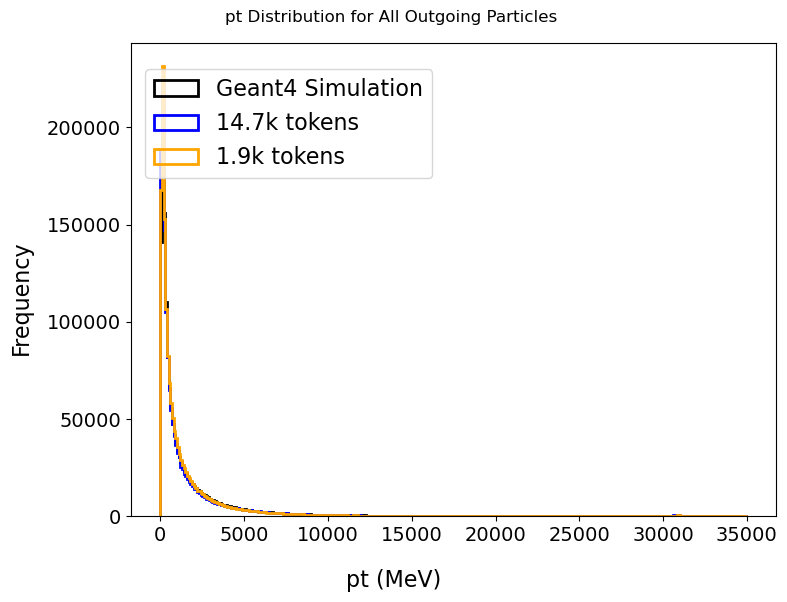

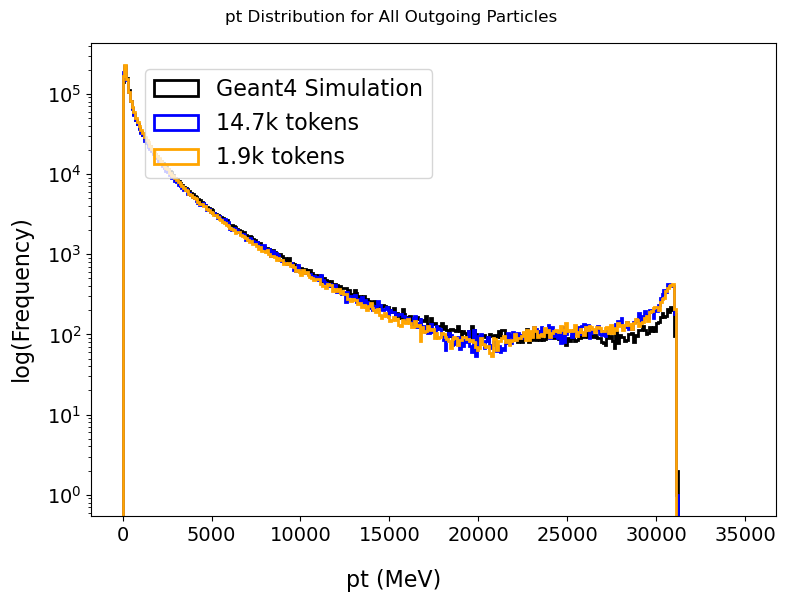

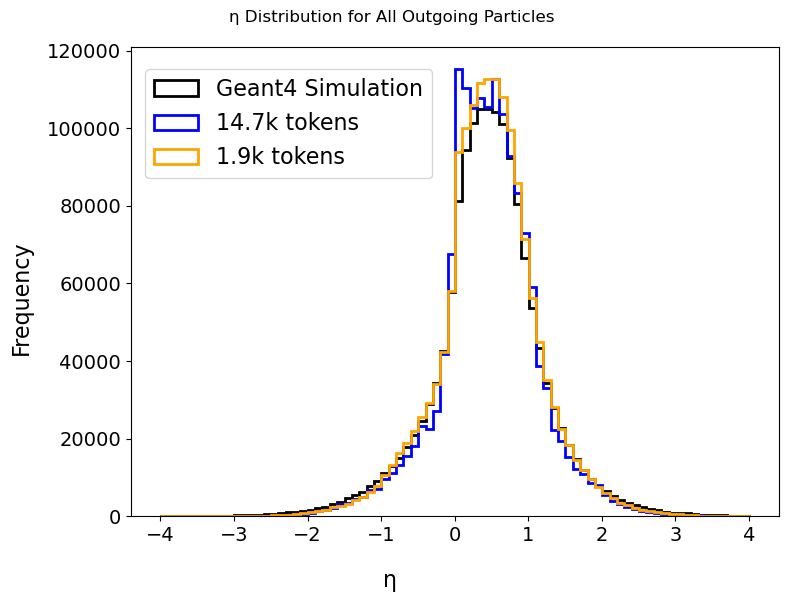

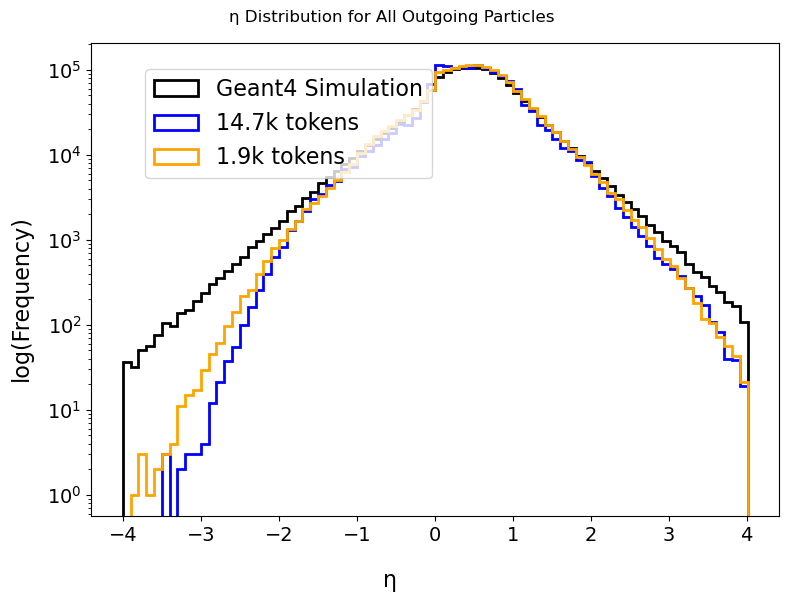

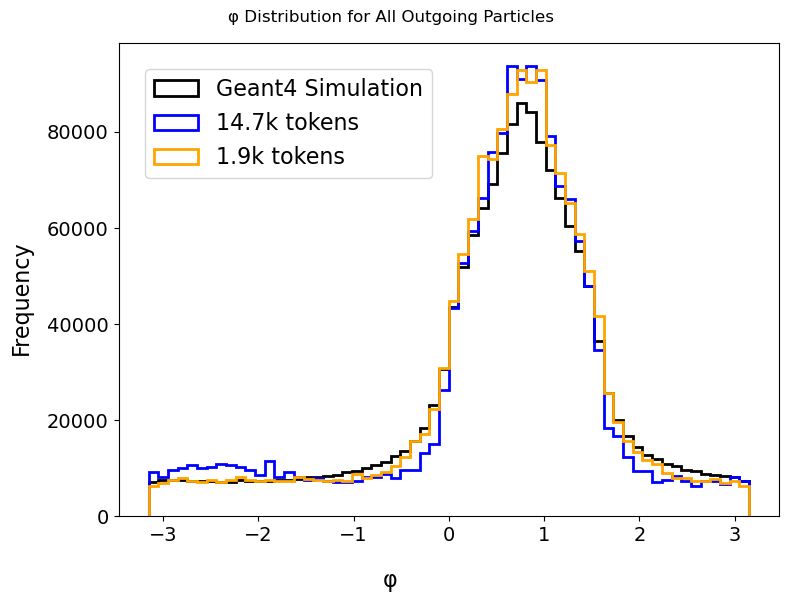

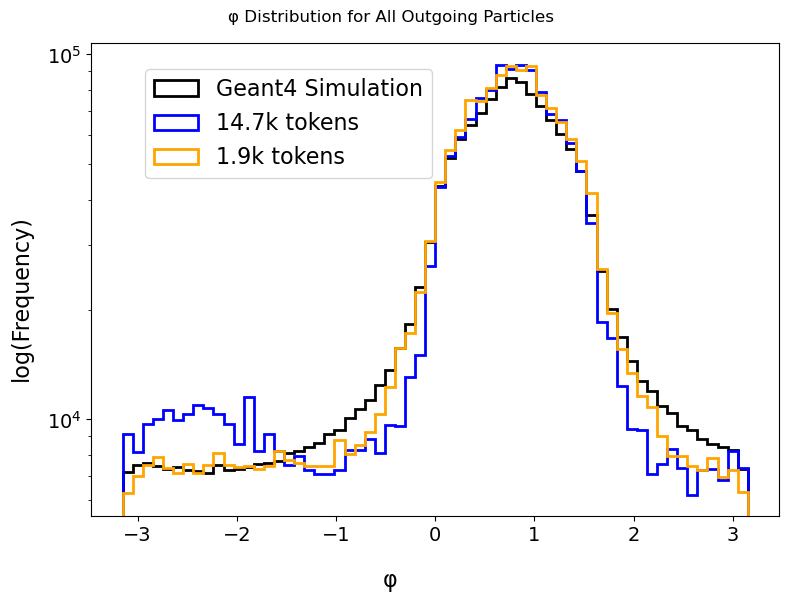

In [ ]:
all_columns = ["pt", "eta", "phi"]
models_to_compare = ['model_10M_9_exp9_vdimlr_1', 'model_10M_12_inclrrestarts_3']
models_legend_title = ['Geant4 Simulation', '14.7k tokens', '1.9k tokens']
for column in all_columns:
    print(column)
    compare_distributions_all(models_to_compare, models_legend_title, column, normalized=False, use_log=False, out_file=parent_dir / 'temp' / f"poster_all_{column}.png")
    # compare_distributions_leading(models_to_compare, models_legend_title, column, normalized=False, use_log=False, out_file=parent_dir / 'temp' / f"poster_leading_{column}.png")
    # compare_distributions_leading(models_to_compare, models_legend_title, column, normalized=False, use_log=True, out_file=parent_dir / 'temp' / f"poster_leading_log_{column}.png")